In [46]:
import torch
import numpy as np 
import pandas as pd
from statistics import fmean
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
import random

le = LabelEncoder()
rng = np.random.default_rng()
file_path = "/media/lars/F77E-7D07/"

In [47]:
unique_pairs = pd.read_csv(file_path + "unique_pairs.csv")

In [48]:
unique_pairs = unique_pairs[(unique_pairs["common_recommended"] >= 10)]

In [49]:
len(unique_pairs)

844736

In [50]:
test = unique_pairs[(unique_pairs["title_1"] == "Factorio") | (unique_pairs["title_2"] == "Factorio")]
test1 = test[test["pmi"] >= -8]["app_id_1"].drop_duplicates()
test2 = test[test["pmi"] >= -8]["app_id_2"].drop_duplicates()
result = pd.concat([test1, test2]).drop_duplicates().tolist()

In [12]:
test[test["pmi"] >= -8]

,app_id_1,title_1,app_id_2,title_2,common_positive,common_recommended,pmi,app_1_recommended,app_2_recommended,common_ratio
3053824,427520,Factorio,1318690,shapez,273.0,291.0,-7.679163,15259.0,781.0,0.017819
3593813,1127400,Mindustry,1318690,shapez,96.0,103.0,-7.626534,1797.0,969.0,0.035901


In [13]:
unique_pairs.sort_values("pmi").head()

,app_id_1,title_1,app_id_2,title_2,common_positive,common_recommended,pmi,app_1_recommended,app_2_recommended,common_ratio
3497830,933110,Age of Empires III: Definitive Edition,1665460,eFootball™ 2024,0.0,19.0,-inf,2018.0,1104.0,0.006049
3469797,895400,Deadside,1147660,ArcheAge: Unchained,0.0,14.0,-inf,1883.0,525.0,0.005780
562729,268130,Heat Signature,393420,Hurtworld,0.0,11.0,-inf,1814.0,1285.0,0.003537
2628720,236110,Dungeon Defenders II,2208920,Assassin's Creed Valhalla,0.0,10.0,-inf,2267.0,848.0,0.003200
2389167,24010,Train Simulator Classic,39690,ArcaniA,0.0,10.0,-inf,1098.0,338.0,0.006916


In [14]:
unique_pairs["label"] = unique_pairs["pmi"] >= -8

In [15]:
(unique_pairs["label"] >=0.5).value_counts()

label
False    832510
True      12226
Name: count, dtype: int64

In [16]:
#unique_pairs = unique_pairs[unique_pairs["common_recommended"] + unique_pairs["app_1_recommended"] + unique_pairs["app_2_recommended"] >= 100]

In [17]:
unique_pairs = unique_pairs.reset_index(drop=True)

In [18]:
games = pd.concat([
    unique_pairs[['app_id_1', 'title_1']].rename(columns={'app_id_1': 'app_id', 'title_1': 'title'}),
    unique_pairs[['app_id_2', 'title_2']].rename(columns={'app_id_2': 'app_id', 'title_2': 'title'})
])

# Drop duplicates to get unique games
games = games.drop_duplicates().reset_index(drop=True)

games


,app_id,title
0,13500,Prince of Persia: Warrior Within™
1,113020,Monaco: What's Yours Is Mine
2,226560,Escape Dead Island
3,250180,METAL SLUG 3
4,253980,Enclave
...,...,...
2663,1303950,Toodee and Topdee
2664,1200330,Strategic Mind: Blitzkrieg
2665,1846460,Burnhouse Lane
2666,1707870,RiffTrax: The Game


In [19]:
unique_pairs = unique_pairs.drop(["title_1", "title_2"],axis=1)

In [21]:
games

,app_id,title
0,13500,Prince of Persia: Warrior Within™
1,113020,Monaco: What's Yours Is Mine
2,226560,Escape Dead Island
3,250180,METAL SLUG 3
4,253980,Enclave
...,...,...
2663,1303950,Toodee and Topdee
2664,1200330,Strategic Mind: Blitzkrieg
2665,1846460,Burnhouse Lane
2666,1707870,RiffTrax: The Game


In [23]:
le.fit(games["app_id"])
le.transform(games["app_id"])

array([  74,  210,  307, ..., 2584, 2521, 2525])

In [24]:
games_1 = pd.DataFrame(le.transform(unique_pairs["app_id_1"]))
games_2 = pd.DataFrame(le.transform(unique_pairs["app_id_2"]))
labels = unique_pairs["label"]

In [25]:
games.to_csv(file_path + "games_network.csv", index=False)
unique_pairs.to_csv(file_path + "unique_pairs_network.csv", index=False)
games_1.to_csv(file_path + "games_1.csv", index=False)
games_2.to_csv(file_path + "games_2.csv", index=False)
labels.to_csv(file_path + "labels.csv", index=False)

In [51]:
# Define the neural network with an embedding layer
class SiameseNN(nn.Module):
    def __init__(self, num_embeddings):
        super(SiameseNN, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings, 16)
    
    def forward_one(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)  # Flatten the embedding output
        output = x
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2
    
    def get_distance(self, input1, input2):
        return F.pairwise_distance(input1, input2, keepdim=True)
    
    def get_embedding(self, x):
        return self.forward_one(x)
    
    

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2)+
                                      (1-label) * torch.pow(torch.clamp((self.margin - euclidean_distance), min=0.0), 2))
        return loss_contrastive




In [53]:
games_1 = pd.read_csv(file_path + "games_1.csv")
games_2 = pd.read_csv(file_path + "games_2.csv")
labels = pd.read_csv(file_path + "labels.csv")
games = pd.read_csv(file_path + "games_network.csv")
unique_pairs = pd.read_csv(file_path + "unique_pairs_network.csv")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Read all data and send to GPU
games_1_tensor = torch.tensor(games_1.values, dtype=torch.long).to(device)
games_2_tensor = torch.tensor(games_2.values, dtype=torch.long).to(device)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32).view(-1, 1).to(device)
games_le = pd.DataFrame(le.fit_transform(games["app_id"]))
games_le_tensor = torch.tensor(games_le.values, dtype=torch.long).to(device)

# Initialize the network, loss function and optimizer
num_embeddings = len(games_le)
model = SiameseNN(num_embeddings).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the saved state dictionary
state_dict = torch.load("siamese_nn.pth")

# Apply the state dictionary to the model
model.load_state_dict(state_dict)

Using device: cuda


/tmp/ipykernel_4801/2034276890.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("siamese_nn.pth")


<All keys matched successfully>

In [28]:
len(unique_pairs[unique_pairs["label"] == False]) / len(unique_pairs[unique_pairs["label"] == True])

68.09340749222967

In [29]:
matching_indices = unique_pairs[(unique_pairs["app_id_1"] == 1318690) | (unique_pairs["app_id_2"] == 1318690)]
matching_indices = matching_indices[matching_indices["label"] == True].index
recommendations = np.zeros(len(unique_pairs), dtype=float)
# Set positions corresponding to matching indices to 1
recommendations[matching_indices] = 1.0

In [30]:
sample_weights = recommendations
sample_weights /= sample_weights.sum()

In [31]:
pdsam = pd.Series(sample_weights)
pdsam.value_counts()

0.0    844734
0.5         2
Name: count, dtype: int64

In [57]:
import time

total_time = 10 * 60
print_time = 10
gpu_size = 80000


recommendations = unique_pairs["common_recommended"]
#recommendations = unique_pairs["common_recommended"] + unique_pairs["app_1_recommended"] + unique_pairs["app_2_recommended"]

start_time = time.time()
print_start = time.time()
num_epochs = 0
losses = 0
last_loss = 1
length = len(unique_pairs)

while time.time() - start_time < total_time:

    sample_weights = recommendations
    sample_weights /= sample_weights.sum()
    sampled_indices = np.random.choice(unique_pairs.index, size=gpu_size, p=sample_weights)

    sampled_games_1 = games_1_tensor[sampled_indices]
    sampled_games_2 = games_2_tensor[sampled_indices]
    sampled_labels = labels_tensor[sampled_indices]

    optimizer.zero_grad()
    output_1, output_2 = model.forward(sampled_games_1, sampled_games_2)
    loss = criterion.forward(output_1, output_2, sampled_labels)
    loss.backward()
    optimizer.step()
    
    losses += loss.item()

    if print_time < (time.time() - print_start):
        print(f'Time elapsed: {int((time.time() - print_start))}s, {num_epochs} epochs, Percentage lost: {((last_loss - (losses / num_epochs)) / last_loss) * 100:.8f}, Loss: {losses / num_epochs:.8f}')

        last_loss = losses / num_epochs
        losses = 0
        print_start = time.time()
        torch.save(model.state_dict(), "siamese_nn.pth")
        num_epochs = 0

    num_epochs += 1

torch.save(model.state_dict(), "siamese_nn.pth")

Time elapsed: 10s, 236 epochs, Percentage lost: 94.02477538, Loss: 0.05975225
Time elapsed: 10s, 239 epochs, Percentage lost: 2.80113460, Loss: 0.05807851
Time elapsed: 10s, 244 epochs, Percentage lost: 1.17220526, Loss: 0.05739771
Time elapsed: 10s, 245 epochs, Percentage lost: 0.70683527, Loss: 0.05699200
Time elapsed: 10s, 240 epochs, Percentage lost: 0.41803770, Loss: 0.05675375
Time elapsed: 10s, 241 epochs, Percentage lost: 0.25593996, Loss: 0.05660850
Time elapsed: 10s, 240 epochs, Percentage lost: 0.18066613, Loss: 0.05650622
Time elapsed: 10s, 246 epochs, Percentage lost: 0.12688206, Loss: 0.05643453
Time elapsed: 10s, 240 epochs, Percentage lost: 0.18046215, Loss: 0.05633268
Time elapsed: 10s, 242 epochs, Percentage lost: 0.25439889, Loss: 0.05618937
Time elapsed: 10s, 238 epochs, Percentage lost: -0.03965821, Loss: 0.05621166
Time elapsed: 10s, 242 epochs, Percentage lost: 0.11596996, Loss: 0.05614647
Time elapsed: 10s, 237 epochs, Percentage lost: 0.12574502, Loss: 0.056075

KeyboardInterrupt: 

In [58]:
torch.save(model.state_dict(), "siamese_nn.pth")

In [59]:
model.eval()

with torch.no_grad():
    embeddings = model.get_embedding(games_le_tensor)

model.train()

games["location"] = list(embeddings.cpu().detach().numpy())
locations_array = np.array(games["location"].tolist())


In [60]:
# Reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
games["location_2d"] = list(tsne.fit_transform(locations_array))

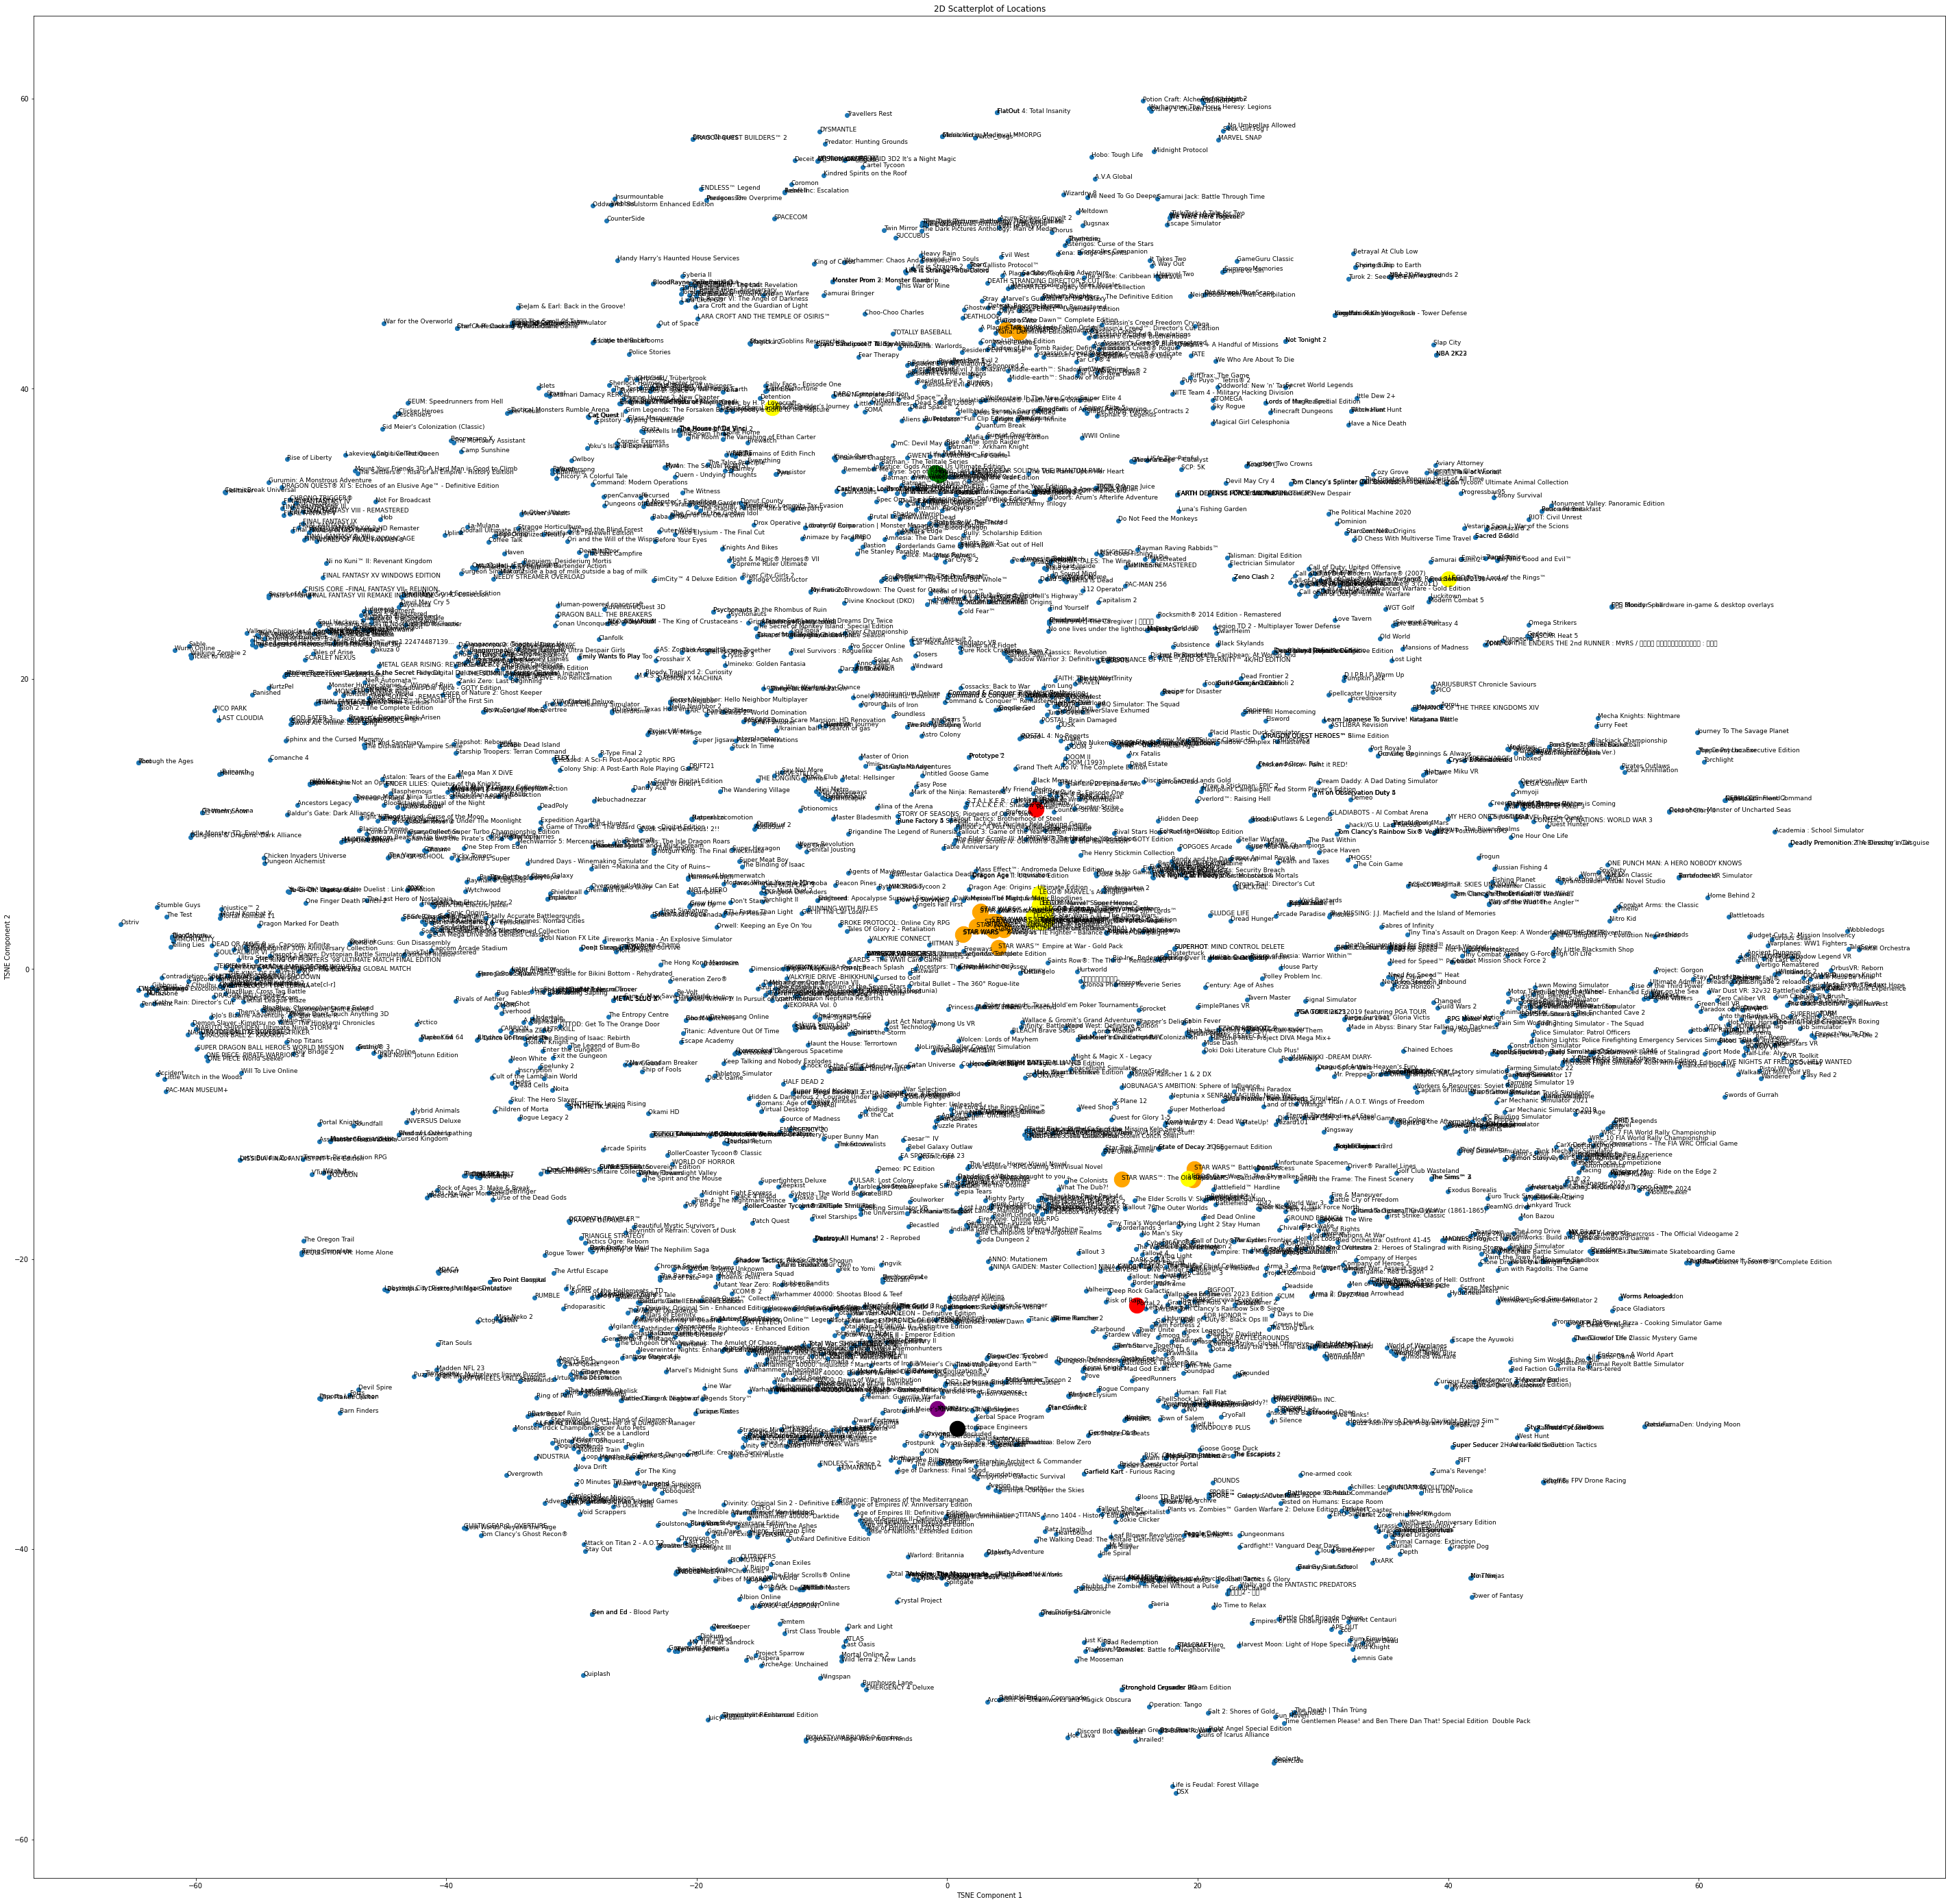

In [62]:
plt.figure(figsize=(50, 50))
plt.scatter(games["location_2d"].apply(lambda x: x[0]), games["location_2d"].apply(lambda x: x[1]))

for i, row in games.iterrows():
    plt.text(row["location_2d"][0], row["location_2d"][1], str(row["title"]), fontsize=9)


for i, row in games.iterrows():
    if str(row["title"]) == "shapez":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='purple', s=500)  # Larger and purple dot
    if str(row["title"]) == "Factorio":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='black', s=500)  # Larger and purple dot
    if str(row["title"]) == "Portal":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='red', s=500)  # Larger and red dot
    if str(row["title"]) == "Portal 2":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='red', s=500)  # Larger and red dot
    if str(row["title"]) == "Metro 2033 Redux":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='green', s=500)  # Larger and green dot
    if str(row["title"]) == "Metro: Last Light Redux":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='green', s=500)  # Larger and green dot
    if str(row["title"]) in list(games[games["title"].str.startswith("LEGO", na=False)]["title"]):
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='yellow', s=500)  # Larger and yellow dot
    if str(row["title"]) in list(games[games["title"].str.startswith("STAR WARS", na=False)]["title"]):
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='orange', s=500)  # Larger and orange dot

""" for i, row in games.iterrows():
    if row["app_id"] in result:
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='purple', s=500)  # Larger and purple dot
    if str(row["title"]) == "Factorio":
        x, y = row["location_2d"][0], row["location_2d"][1]
        plt.scatter(x, y, color='yellow', s=500)  # Larger and purple dot """

plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.title("2D Scatterplot of Locations")
plt.show()

In [63]:
games.to_csv("filtered_archive/games_locations.csv")

In [64]:
games

,app_id,title,location,location_2d
0,13500,Prince of Persia: Warrior Within™,"[-1.866102, 0.99451023, 0.40603468, -0.2380058...","[24.186802, 0.77621037]"
1,113020,Monaco: What's Yours Is Mine,"[0.020442933, -0.5393589, -0.2917314, -0.54862...","[-17.874107, 5.857071]"
2,226560,Escape Dead Island,"[-0.3653058, 0.65042776, -1.2611274, -0.556310...","[-35.764282, 15.349469]"
3,250180,METAL SLUG 3,"[0.38056952, -0.74179775, -0.40242398, -0.0973...","[-26.696531, -2.167464]"
4,253980,Enclave,"[-1.4758933, -0.5198025, 0.40263924, 0.9107056...","[-31.929512, 4.823961]"
...,...,...,...,...
2663,1303950,Toodee and Topdee,"[0.05428421, -0.7462316, -0.23424883, 0.398018...","[31.304539, 26.444195]"
2664,1200330,Strategic Mind: Blitzkrieg,"[0.1955202, 0.21247195, -0.19270533, 0.2784302...","[-15.7921095, -32.04351]"
2665,1846460,Burnhouse Lane,"[0.6145816, -1.3686105, -0.2536894, 0.9759025,...","[-6.781036, -49.33562]"
2666,1707870,RiffTrax: The Game,"[-0.9136235, 0.07417812, 1.0466357, -0.1724529...","[19.394258, 40.77185]"
